In [35]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import math
import yfinance as yf
import matplotlib.pyplot as plt


In [36]:
def const_binomial_tree(n):
    for i in range(n):
        x = [1, 0, 1]
        for j in range(i):
            x.append(0)
            x.append(1)
        x = np.array(x) + i
        y = np.arange(-(i+1), i+2)[::-1]
        #y = np.arange(n-1-i, n+2+i)[::-1]
        plt.plot(x, y, 'bo-')
    plt.show()

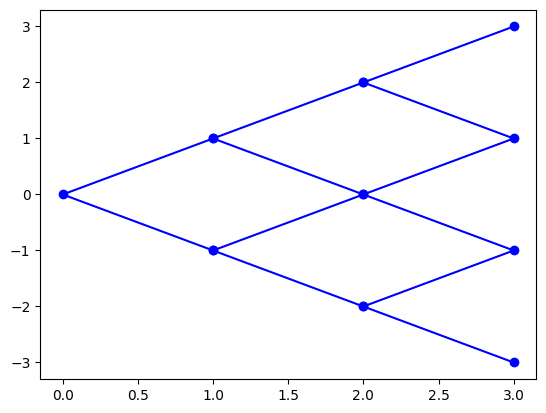

In [37]:
const_binomial_tree(3)

## Inputs

In [38]:
T = 1
n = 10
dt = T / n
r = 0.05 * T
m = 1+r
u = 1.1
d = 1/1.1
p = (1+r-d)/(u-d)
q = 1-p
s0 = 100
K = 100
option_type = 'P'

## Binomial tree

In [39]:
def binomial_tree(n, u, d, s0):
    prices = np.zeros((n+1, n+1))
    prices[0, 0] = s0
    for i in range(1, n+1):
        prices[0:i, i] = prices[0:i, i-1] * u
        prices[i, i] = prices[i-1, i-1] * d
    return prices

In [40]:
stock_prices = binomial_tree(n, u, d, s0)
stock_prices

array([[100.        , 110.        , 121.        , 133.1       ,
        146.41      , 161.051     , 177.1561    , 194.87171   ,
        214.358881  , 235.7947691 , 259.37424601],
       [  0.        ,  90.90909091, 100.        , 110.        ,
        121.        , 133.1       , 146.41      , 161.051     ,
        177.1561    , 194.87171   , 214.358881  ],
       [  0.        ,   0.        ,  82.6446281 ,  90.90909091,
        100.        , 110.        , 121.        , 133.1       ,
        146.41      , 161.051     , 177.1561    ],
       [  0.        ,   0.        ,   0.        ,  75.13148009,
         82.6446281 ,  90.90909091, 100.        , 110.        ,
        121.        , 133.1       , 146.41      ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         68.30134554,  75.13148009,  82.6446281 ,  90.90909091,
        100.        , 110.        , 121.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  62.09213231,  68.3

In [41]:
def draw_bin_tree(n, u, d, s0):
    tree = binomial_tree(n, u, d, s0)
    y = []
    for i in range(n+1):
        for j in tree[:, i]:
            if j != 0:
                y.append((j, i))
    y = np.array(y)
    plt.scatter(y[:, 1], y[:, 0])

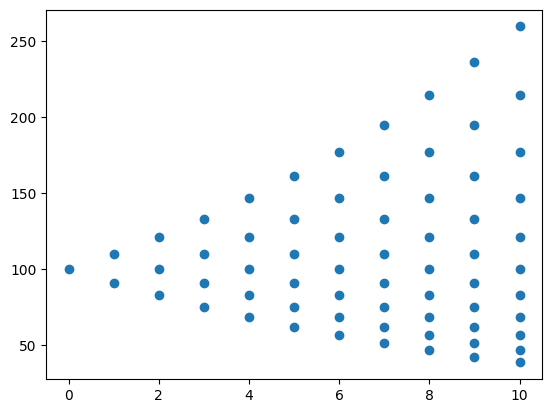

In [42]:
draw_bin_tree(n, u, d, s0)

## Option payoff at maturity

In [43]:
def option_maturity_payoffs(stock_prices, K, option_type):
    if option_type == 'C':
        payoffs = stock_prices[:, len(stock_prices)-1] - K
    else:
        payoffs = K - stock_prices[:, len(stock_prices)-1]
    for j in range(len(payoffs)):
        payoffs[j] = max(0, payoffs[j])
    return payoffs

In [44]:
maturity_payoff = option_maturity_payoffs(stock_prices, K, option_type)
maturity_payoff

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 17.3553719 , 31.69865446, 43.55260699, 53.34926198,
       61.44567106])

### Backward recursion to determine option price at time 0

In [45]:
def backward_payoffs(n, r, p, stock_prices, maturity_payoff):
    back_option_payoffs = np.zeros((n+1, n+1))
    back_option_payoffs[:, n] = maturity_payoff
    for i in range(n-1, -1, -1):
        for j in range(n-1, -1, -1):
            if stock_prices[i][j] != 0:
                back_option_payoffs[i][j] = (1/m)*(back_option_payoffs[i][j+1]*p + back_option_payoffs[i+1][j+1]*q) 
    return back_option_payoffs

In [46]:
b_payoffs = backward_payoffs(n, r, p, stock_prices, maturity_payoff)
b_payoffs

array([[3.09666413e-01, 1.60159325e-01, 6.91924683e-02, 2.24716422e-02,
        4.17982884e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.90122704e-01, 4.47096337e-01, 2.14069722e-01,
        7.83113387e-02, 1.67573138e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.90767498e+00, 1.18916246e+00,
        6.37529386e-01, 2.66732119e-01, 6.71815945e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.29676640e+00,
        2.97078669e+00, 1.80421366e+00, 8.80023366e-01, 2.69337120e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.85391005e+00, 6.82555179e+00, 4.75319073e+00, 2.76905270e+00,
        1.07979700e+00, 0.00000000e+00, 0.00000000e+

In [47]:
def draw_payoffs(b_payoffs):
    tree = b_payoffs
    y = []
    for i in range(n+1):
        for j in range(len(tree[:, i])):
            if tree[j, i] != 0 or  i>=j:
                y.append((tree[j, i], i))
    y = np.array(y)
    plt.scatter(y[:, 1], y[:, 0])

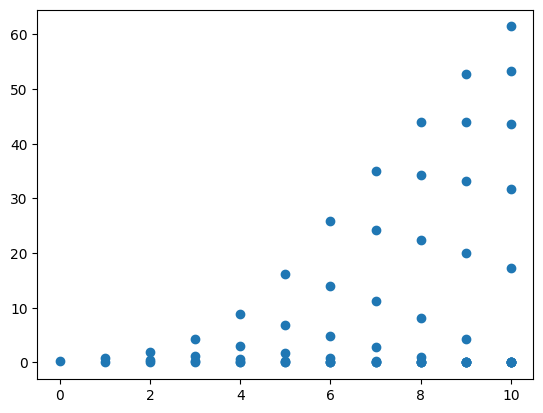

In [48]:
draw_payoffs(b_payoffs)

### American put options

In [49]:
def put_anticipated_payoffs(b_payoffs, K, stock_prices):
    intrinsic_value = np.zeros((n+1, n+1))
    intrinsic_value[:, n] = b_payoffs[:, n]
    for i in range(n-1, -1, -1):
        for j in range(n-1, -1, -1):
            if b_payoffs[i][j] != 0:
                intrinsic_value[i][j] = max(b_payoffs[i][j], K - stock_prices[i][j])
    intrinsic_value[0][0] = (1/m)*(p*intrinsic_value[1][0]+q*intrinsic_value[1][1])
    return intrinsic_value

In [50]:
b_payoffs = put_anticipated_payoffs(b_payoffs, K, stock_prices)
b_payoffs

array([[2.26757370e+00, 1.60159325e-01, 6.91924683e-02, 2.24716422e-02,
        4.17982884e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.09090909e+00, 4.47096337e-01, 2.14069722e-01,
        7.83113387e-02, 1.67573138e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.73553719e+01, 9.09090909e+00,
        6.37529386e-01, 2.66732119e-01, 6.71815945e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.48685199e+01,
        1.73553719e+01, 9.09090909e+00, 8.80023366e-01, 2.69337120e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.16986545e+01, 2.48685199e+01, 1.73553719e+01, 9.09090909e+00,
        1.07979700e+00, 0.00000000e+00, 0.00000000e+

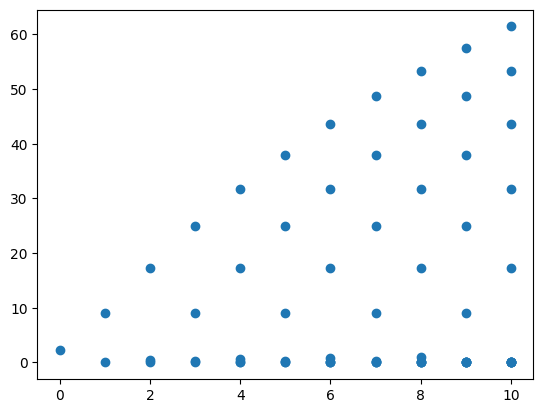

In [51]:
draw_payoffs(b_payoffs)

## Practical usage

In [52]:
r = np.log(1+r)
m = np.exp(r*dt)
sigma = 0.2
u = np.exp(sigma*np.sqrt(dt))
d = 1/u
p = (m - d)/(u-d)
q = 1-p

In [53]:
def combination(n, k):
    return math.factorial(n) / (math.factorial(k)*math.factorial(n - k))
    
def binomial_f(k, n, p):
    return combination(n, k)*(p**k)*(1-p)**(n-k)

In [85]:
def payoff(n, p, u, d, S0, K, option_type):
    pay = 0
    for k in range(n+1):
        if option_type == 'call':
            pay += binomial_f(k, n, p) * max(0, S0*(u**k)*(d**(n-k)) - K)
        else:
            pay += binomial_f(k, n, p) * max(0, K - (u**k)*(d**(n-k))*S0)
    return np.exp(-r*T) * pay

In [86]:
price = payoff(n, p, u, d, s0, K, 'call')
price

10.189244810034984

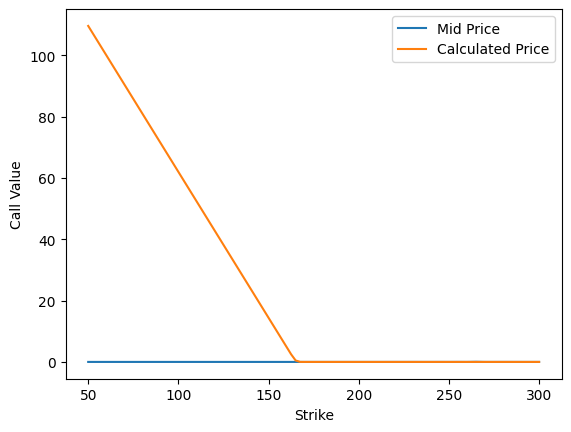

In [132]:
def binomial_formula(S0, K , T, r, sigma, N, option_type):
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (  np.exp(r*dt) - d )  /  (  u - d )
    return payoff(N, p, u, d, S0, K, option_type)

#def binom_EU1(S0, K , T, r, sigma, N, type_ = 'call'):
#    dt = T/N
#    u = np.exp(sigma * np.sqrt(dt))
#    d = np.exp(-sigma * np.sqrt(dt))
#    p = (  np.exp(r*dt) - d )  /  (  u - d )
#    value = 0 
#    for i in range(N+1):
#        node_prob = combination(N, i)*p**i*(1-p)**(N-i)
#        ST = S0*(u)**i*(d)**(N-i)
#        if type_ == 'call':
#            value += max(ST-K,0) * node_prob
#        elif type_ == 'put':
#            value += max(K-ST, 0)*node_prob
#
#    return value*np.exp(-r*T)
    


def get_data(symbol, n):
    obj = yf.Ticker(symbol)
    expiry_dates = obj.options
    options = obj.option_chain(expiry_dates[n])
    df = options.calls
    df.reset_index(inplace=True)
    df['Time'] = (datetime.datetime.strptime(expiry_dates[n], '%Y-%m-%d') - datetime.datetime.now()).days
    df['expiration'] = datetime.datetime.strptime(expiry_dates[n], '%Y-%m-%d')
    df['mid_price'] = (df.bid + df.ask) / 2
    return df

df = get_data('AAPL', 1)

prices = [] 

for row in df.itertuples():
    price = binomial_formula(165, row.strike, row.Time / 255, 0.03, 0.018 * np.sqrt(row.Time), 100, 'call')
    prices.append(price)
    
df['Price'] = prices
df['error'] = df.mid_price - df.Price 

plt.plot(df.strike, df.mid_price, label= 'Mid Price')
plt.plot(df.strike, df.Price, label = 'Calculated Price')
plt.xlabel('Strike')
plt.ylabel('Call Value')
plt.legend()


In [78]:
df.head()

,index,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Time,expiration,mid_price,Price,error
0,0,AAPL230421C00050000,2023-04-10 15:10:29+00:00,50.0,111.25,0.0,0.0,0.0,0.0,4,1173,0.00001,True,REGULAR,USD,6,2023-04-21,0.0,70.671552,-70.671552
1,1,AAPL230421C00060000,2023-04-05 13:40:06+00:00,60.0,104.95,0.0,0.0,0.0,0.0,10,187,0.00001,True,REGULAR,USD,6,2023-04-21,0.0,64.532420,-64.532420
2,2,AAPL230421C00065000,2023-04-13 17:41:13+00:00,65.0,99.83,0.0,0.0,0.0,0.0,1,114,0.00001,True,REGULAR,USD,6,2023-04-21,0.0,61.462853,-61.462853
3,3,AAPL230421C00070000,2023-04-05 13:45:39+00:00,70.0,94.70,0.0,0.0,0.0,0.0,2,217,0.00001,True,REGULAR,USD,6,2023-04-21,0.0,58.393287,-58.393287
4,4,AAPL230421C00075000,2023-04-05 13:32:00+00:00,75.0,89.65,0.0,0.0,0.0,0.0,1,118,0.00001,True,REGULAR,USD,6,2023-04-21,0.0,55.323721,-55.323721


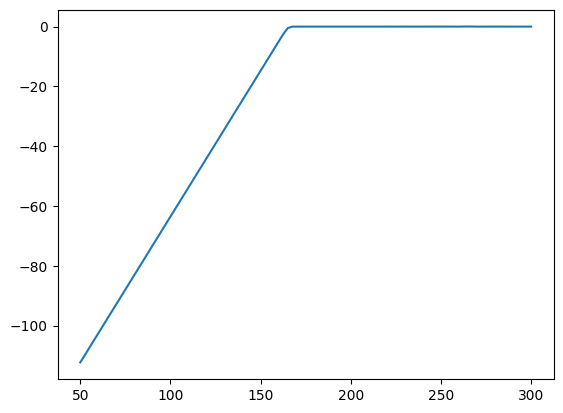

In [70]:
plt.plot(df.strike, df.error);

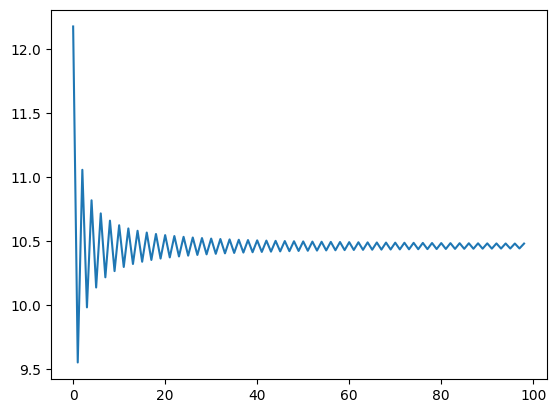

In [90]:
prices = []
for i in range(1, 100):
  prices.append(binomial_formula(100, 100, 1, 0.05, 0.2, i, 'call'))

plt.plot(prices)

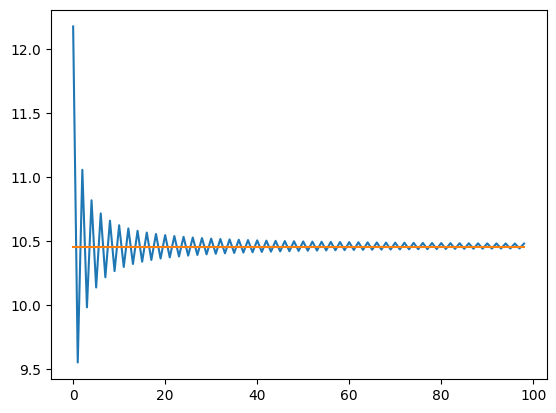

In [99]:
from scipy.stats import norm

N = norm.cdf
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

prices1 = []
for i in range(1, 100):
  prices1.append(BS_CALL(100, 100, 1, 0.05, 0.2))

prices = []
for i in range(1, 100):
  prices.append(binomial_formula(100, 100, 1, 0.05, 0.2, i, 'call'))

plt.plot(prices)
plt.plot(prices1)

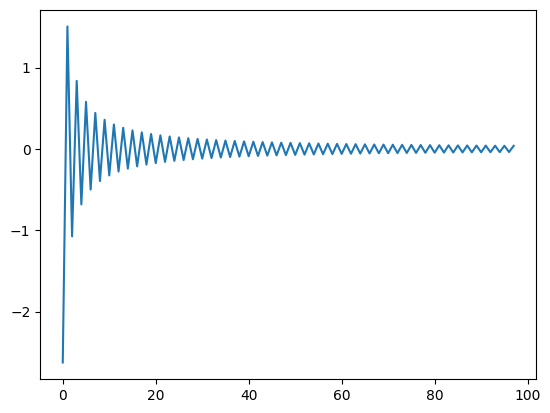

In [106]:
scarti = []
for i in range(1, 99):  
  scarti.append(np.array(prices)[i] - np.array(prices)[i-1])
plt.plot(scarti)

(1.0, 100.0)

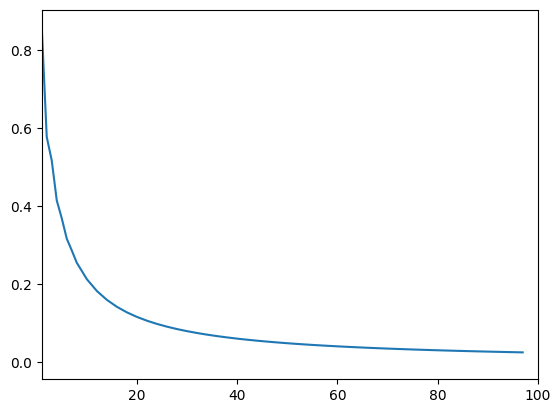

In [131]:

stds = []
N = 100
for j in range(2, N):
  prices = []
  for i in range(1, j):
    prices.append(binomial_formula(100, 100, 1, 0.05, 0.2, i, 'call'))

  somma = 0
  for i in range (j-1):
    somma += (prices[i] - sum(prices)/len(prices))**2
  variance = (1/len(prices)) * somma
  stds.append(variance ** 1/2)

plt.plot(stds)
plt.xlim(1, 100)
